In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

pd.set_option('max_columns', 8, 'max_rows', 10)

# Auctions Ventana 1

In [26]:
# Leo el .csv, ordeno por fecha
auctions = pd.read_csv('data/auctions_ventanas/auctions_2019-04-18-2019-04-20.csv', low_memory=False, parse_dates = ['date'], index_col=['date'])
auctions = auctions.sort_index()
auctions.head()

,device_id,ref_type_id,source_id
date,,,
2019-04-18 00:00:00.015050,1826643666390887030,7,0
2019-04-18 00:00:00.029014,7037174172278258682,1,0
2019-04-18 00:00:00.057540,3392065368947589877,1,1
2019-04-18 00:00:00.126828,1228982273563226229,1,1
2019-04-18 00:00:00.132510,4123059034628125459,1,8


In [27]:
# device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
auctions = auctions.reset_index()
auctions = auctions.rename(index=str, columns={'device_id' : 'ref_hash'})
auctions = auctions.drop_duplicates(subset='ref_hash')
auctions.head()

,date,ref_hash,ref_type_id,source_id
0,2019-04-18 00:00:00.015050,1826643666390887030,7,0
1,2019-04-18 00:00:00.029014,7037174172278258682,1,0
2,2019-04-18 00:00:00.057540,3392065368947589877,1,1
3,2019-04-18 00:00:00.126828,1228982273563226229,1,1
4,2019-04-18 00:00:00.132510,4123059034628125459,1,8


## Cálculo de labels

In [28]:
# Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
auctions['date'] = auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')
auctions['date'] = auctions['date'].transform(lambda x: x.total_seconds())
auctions

,date,ref_hash,ref_type_id,source_id
0,0.015050,1826643666390887030,7,0
1,0.029014,7037174172278258682,1,0
2,0.057540,3392065368947589877,1,1
3,0.126828,1228982273563226229,1,1
4,0.132510,4123059034628125459,1,8
...,...,...,...,...
15644489,259196.265259,3249485961899571550,7,1
15644543,259196.949571,6935058777451259898,1,1
15644607,259197.827543,4775315369292092311,1,0
15644683,259198.834158,587301283475662820,7,1


## Entrenamiento y predicción del modelo

In [29]:
features = auctions[['ref_hash', 'ref_type_id', 'source_id']]
labels = auctions['date']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=123)

In [30]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
y_pred = regressor.predict(X_test)

## Chequeo de resultados

In [32]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
1030418,12356.824843,78624.120194
6400403,99314.889025,78670.630726
141791,1729.861089,78795.914522
8383836,144340.935987,78705.154887
5836,70.860476,78435.545465
...,...,...
67983,802.751630,78667.582088
2541214,46893.104391,78598.700586
269882,3374.718127,78432.273775
2184766,28972.045184,78829.681626


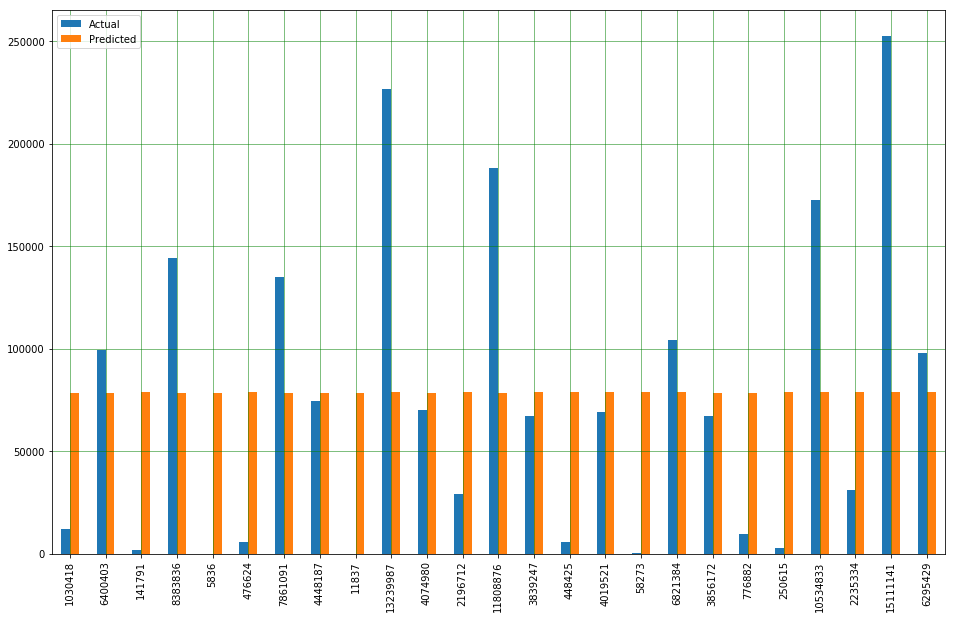

In [33]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 61223.057302381545
Mean Squared Error: 5439744091.578473
Root Mean Squared Error: 73754.62081509519
